# Fire Data and Combined Fire & Forest Grid DataFrame

This notebook creates an Ontario Fire DataFrame containing polygon geometry on fires within Ontario from 2001 to 2021 based on a shapefile with point geometry on fires in Canada.
The fire DataFrame is joined to the forest DataFrame using a spatial join to the forest pixel grid.

The ON_fire dataframe consists of fire data that were spatially joined to our current forest pixel grid. This one done sjoinging the forest data onto the fire data. A buffer polygon was created based on the area of the fire, centered at its cendroid. Then the joinging was done to see how many of our 250mx250m pixels coordinates intersected with the fire area polygon. We can now map the fires based on there areas on our coordinate grid.

# 1. Import Modules and Packages

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
import seaborn as sns

# 2. Import Canada Fire Data

In [ ]:
# Read the shapefile containing centroid point geometry data on all fires in Canada upto 2021 from the National Fire DataBase
# (NFBD) website.
# Read the Shapefile into a GeoDataFrame and convert the coordinate system to EPSG code 3347.

NFDB_point_Canada = gpd.read_file('NFDB_point_20220901.shp')
NFDB_point_Canada = NFDB_point_Canada.to_crs('EPSG:3347')

NFDB_point_Canada.head()

,SRC_AGENCY,FIRE_ID,FIRENAME,LATITUDE,LONGITUDE,YEAR,MONTH,DAY,REP_DATE,ATTK_DATE,...,CFS_REF_ID,CFS_NOTE1,CFS_NOTE2,ACQ_DATE,SRC_AGY2,ECOZONE,ECOZ_REF,ECOZ_NAME,ECOZ_NOM,geometry
0,BC,1953-G00041,None,59.963,-128.172,1953,5,26,1953-05-26,None,...,BC-1953-1953-G00041,None,None,2020-05-05,BC,12,12,Boreal Cordillera,CordillCre boreale,POINT Z (4333891.896 3176789.985 0.000)
1,BC,1950-R00028,None,59.318,-132.172,1950,6,22,1950-06-22,None,...,BC-1950-1950-R00028,None,None,2020-05-05,BC,12,12,Boreal Cordillera,CordillCre boreale,POINT Z (4113552.946 3243500.101 0.000)
2,BC,1950-G00026,None,59.876,-131.922,1950,6,4,1950-06-04,None,...,BC-1950-1950-G00026,None,None,2020-05-05,BC,12,12,Boreal Cordillera,CordillCre boreale,POINT Z (4160334.403 3284180.242 0.000)
3,BC,1951-R00097,None,59.760,-132.808,1951,7,15,1951-07-15,None,...,BC-1951-1951-R00097,None,None,2020-05-05,BC,12,12,Boreal Cordillera,CordillCre boreale,POINT Z (4114004.738 3302811.934 0.000)
4,BC,1952-G00116,None,59.434,-126.172,1952,6,12,1952-06-12,None,...,BC-1952-1952-G00116,None,None,2020-05-05,BC,12,12,Boreal Cordillera,CordillCre boreale,POINT Z (4396754.854 3070387.438 0.000)


# 3. Exploring and Modifying the Fire Data

The 'NFDB_point_Canada' DataFrame contains data on fires within all of Canada. It is modified to include only data for Ontario from 2001-2021.
Plots are made to visualize the fires within Ontario.

In [ ]:
# Codes below narrow down the 'NFDB_point_Canada' DataFrame to include only fires in Ontario from 2001 to the most recent year
# of data (2021).

NFDB_point_Ontario = NFDB_point_Canada[NFDB_point_Canada['SRC_AGENCY'] == 'ON']
NFDB_point_Ontario_2001 = NFDB_point_Ontario[NFDB_point_Ontario['YEAR'] >= 2001].reset_index(drop=True)

NFDB_point_Ontario_2001.head()

,SRC_AGENCY,FIRE_ID,FIRENAME,LATITUDE,LONGITUDE,YEAR,MONTH,DAY,REP_DATE,ATTK_DATE,...,CFS_REF_ID,CFS_NOTE1,CFS_NOTE2,ACQ_DATE,SRC_AGY2,ECOZONE,ECOZ_REF,ECOZ_NAME,ECOZ_NOM,geometry
0,ON,RED19,None,50.724709,-92.098508,2020,7,3,2020-07-03,None,...,ON-2020-RED19,None,None,2021-04-12,ON,6,6a,Boreal Shield West,Bouclier bordal,POINT Z (6183732.734 1620232.609 0.000)
1,ON,THU63,None,49.001309,-89.426207,2020,8,19,2020-08-19,None,...,ON-2020-THU63,None,None,2021-04-12,ON,6,6a,Boreal Shield West,Bouclier bordal,POINT Z (6378523.401 1432558.822 0.000)
2,ON,KEN22,None,49.543509,-94.406209,2020,7,9,2020-07-09,None,...,ON-2020-KEN22,None,None,2021-04-12,ON,6,6a,Boreal Shield West,Bouclier bordal,POINT Z (6016636.740 1493032.361 0.000)
3,ON,THU23,None,50.455109,-89.857708,2020,7,3,2020-07-03,None,...,ON-2020-THU23,None,None,2021-04-12,ON,6,6a,Boreal Shield West,Bouclier bordal,POINT Z (6341877.825 1592628.950 0.000)
4,ON,KLK4,None,48.053909,-80.284004,2020,7,5,2020-07-05,None,...,ON-2020-KLK4,None,None,2021-04-12,ON,6,6b,Boreal Shield East,Bouclier bordal,POINT Z (7061935.777 1402282.324 0.000)


In order to know the where the most southern fire occured, the row with the most southern latitude is found. This allows the forest and climate data to be filtered to exclude areas below this latitude.

In [ ]:
# Find the row with the most southern latitude.
most_southern_row = NFDB_point_Ontario_2001[NFDB_point_Ontario_2001['LATITUDE'] == NFDB_point_Ontario_2001['LATITUDE'].min()]

# Retrieve the longitude corresponding to the most southern latitude.
most_southern_longitude = most_southern_row['LONGITUDE'].values[0]

# Print the most southern latitude and its corresponding longitude.
print("Most southern latitude:", most_southern_row['LATITUDE'].values[0])
print("Longitude corresponding to the most southern latitude:", most_southern_longitude)

Most southern latitude: 42.2528
Longitude corresponding to the most southern latitude: -81.8606


Display all the fires from 2001 to 2021 on the Map of Ontario

In [ ]:
# Create a map of Ontario based on the coordinates of the GeoDataFrame
# Map of fires in Ontario from 2001-2021

from folium import Circle

gdf_reprojected = NFDB_point_Ontario_2001.to_crs(epsg=4326)
location=[gdf_reprojected.geometry.y.mean(), gdf_reprojected.geometry.x.mean()]

map_4 = folium.Map(location,tiles='cartodbpositron',zoom_start=5)

# Add points to the map
for idx, row in gdf_reprojected.iterrows():
    Circle(location=[row.LATITUDE, row.LONGITUDE],
           radius=40,
           color='brown').add_to(map_4)

# Display map
map_4

Output hidden; open in https://colab.research.google.com to view.

To visualize the yearly distribution of fires, a plot of the yearly fires from 2001 to 2021 is made.

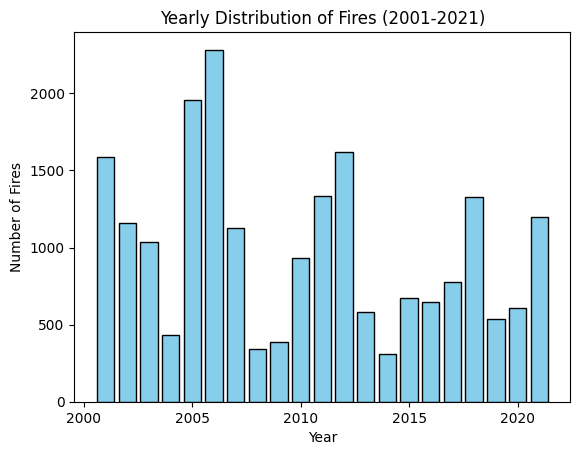

In [ ]:
# Group the ON_fires from 2001 to 2021 by year and count the number of fires in each year.
yearly_counts = NFDB_point_Ontario_2001.groupby('YEAR').size()

# Create a bar plot for the distribution of yearly fires.
plt.bar(yearly_counts.index, yearly_counts, color='skyblue', edgecolor='black')
plt.title('Yearly Distribution of Fires (2001-2021)')
plt.xlabel('Year')
plt.ylabel('Number of Fires')

# Export as a .png file
plt.savefig('Yearly Distribution of Fires (2001-2021).png')

plt.show()


To visualize some of the fires, using for example the fires in 2001, 2006, 2011, and 2021, the fires are further narrowed down and plotted.

In [ ]:
# Ontario data for 2001 only.
NFDB_point_Ontario_2001_only = NFDB_point_Ontario_2001[NFDB_point_Ontario_2001['YEAR'] == 2001].reset_index(drop=True)
NFDB_point_Ontario_2001_only.head()

,SRC_AGENCY,FIRE_ID,FIRENAME,LATITUDE,LONGITUDE,YEAR,MONTH,DAY,REP_DATE,ATTK_DATE,...,CFS_REF_ID,CFS_NOTE1,CFS_NOTE2,ACQ_DATE,SRC_AGY2,ECOZONE,ECOZ_REF,ECOZ_NAME,ECOZ_NOM,geometry
0,ON,COC2,NaN,56.0126,-87.7137,2001,5,27,2001-05-27,NaN,...,ON-2001-COC2,NaN,NaN,2020-04-03,ON,15,15,Hudson Plain,Plaines hudsonniennes,POINT Z (6453342.252 2208531.265 0.000)
1,ON,SLK18,NaN,53.0109,-89.7083,2001,6,9,2001-06-09,NaN,...,ON-2001-SLK18,NaN,NaN,2020-04-03,ON,6,6a,Boreal Shield West,Bouclier bordal,POINT Z (6342870.833 1874437.342 0.000)
2,ON,SLK52,NaN,53.8230,-90.9870,2001,7,21,2001-07-21,NaN,...,ON-2001-SLK52,NaN,NaN,2020-04-03,ON,6,6a,Boreal Shield West,Bouclier bordal,POINT Z (6257006.464 1961454.412 0.000)
3,ON,NIP27,NaN,51.4019,-87.6397,2001,6,9,2001-06-09,NaN,...,ON-2001-NIP27,NaN,NaN,2020-04-03,ON,6,6a,Boreal Shield West,Bouclier bordal,POINT Z (6491403.773 1704662.863 0.000)
4,ON,NIP32,NaN,51.6912,-87.1953,2001,6,9,2001-06-09,NaN,...,ON-2001-NIP32,NaN,NaN,2020-04-03,ON,6,6a,Boreal Shield West,Bouclier bordal,POINT Z (6519647.586 1738614.308 0.000)


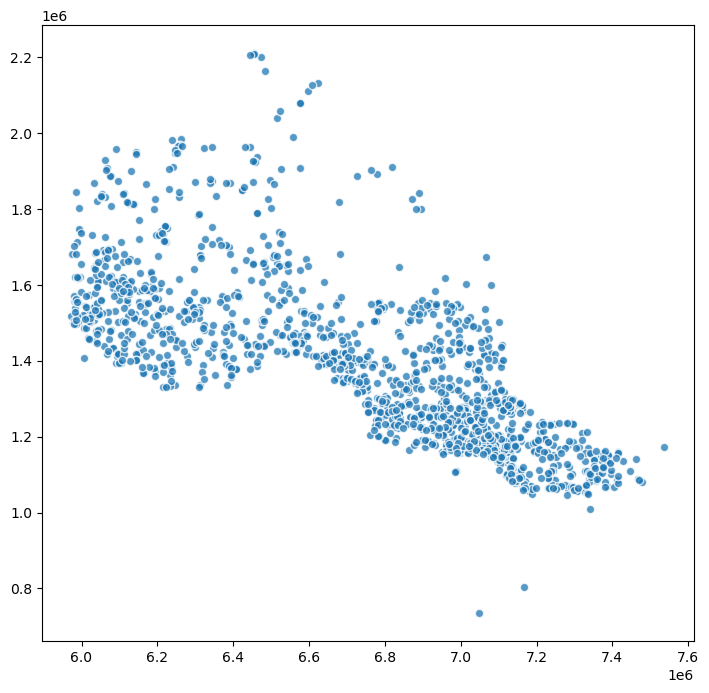

In [ ]:
# Plot the GeoDataFrame 'NFDB_point_Ontario_2001_only' which contains only the fires in 2001.

NFDB_point_Ontario_2001_only.plot(figsize=(15, 8), edgecolor='w', alpha=0.75);
plt.show()

Plot the 2001 fires on the map of Toronto to visualize the location of the fires with respect to different areas in Toronto.

For more exploratory analysis, plots of the monthly distribution of fires in 2001, 2006, 2011, and 2021 are made to determine the monthly fire distribution in each of these years. 2001 and 2021 selected to display fires in the oldest and most recent years; 2011 selected to display data in the mid year;2006 selected to display fires in the year with the highest number of fires.


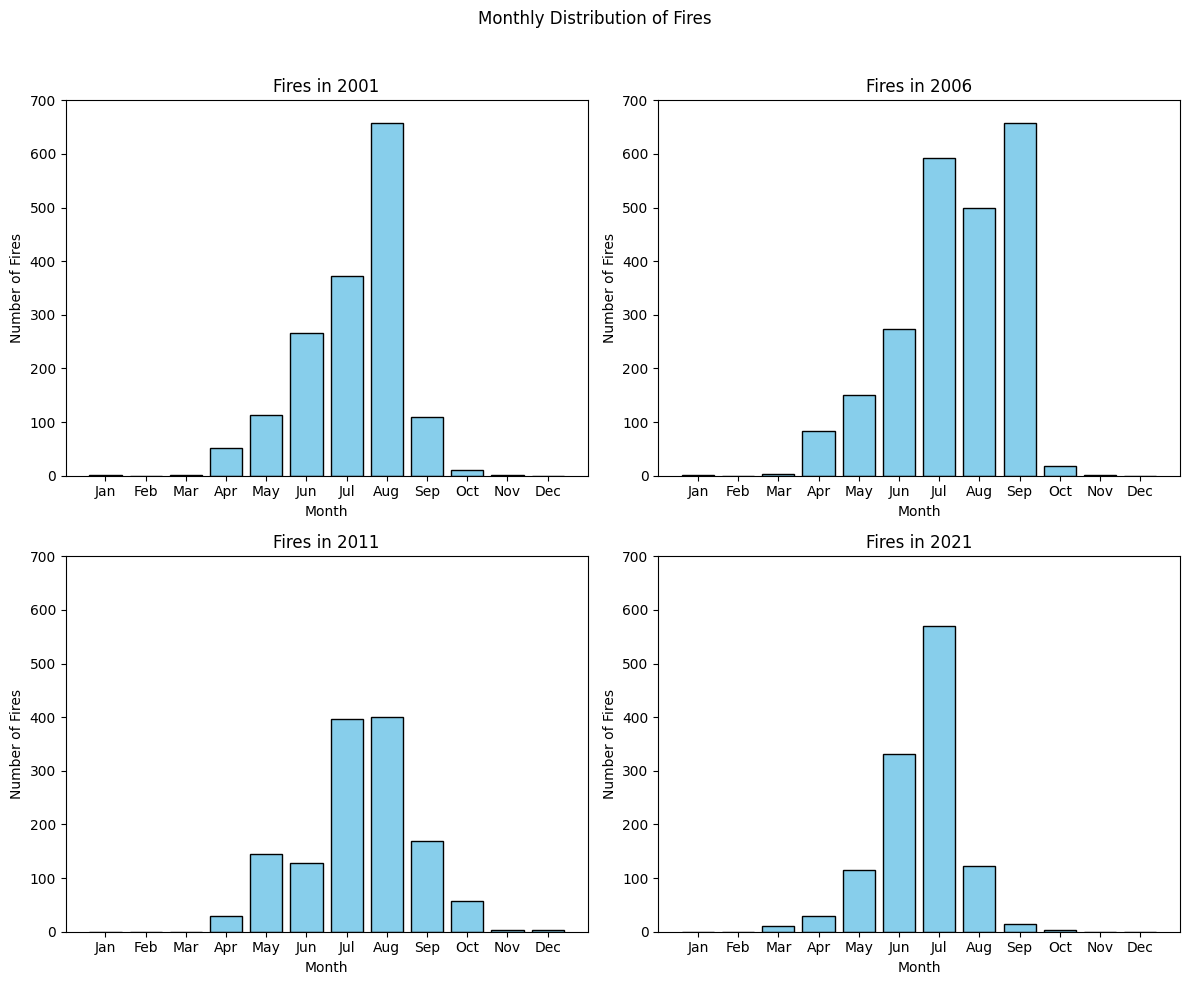

In [ ]:
# Group fires for the specific years and plot the count of the fires in each month.

# Filter data for each specific year
years_to_plot = [2001, 2006, 2011, 2021]

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Monthly Distribution of Fires')

# Use a for loop to iterate through each year chosen for the plot
for i, year in enumerate(years_to_plot, 1):
    # Calculate monthly counts for the specific year
    data_for_year = NFDB_point_Ontario_2001[NFDB_point_Ontario_2001['YEAR'] == year]
    monthly_counts = data_for_year.groupby('MONTH').size()

    # If there is no data for a particular month, fill the count with 0
    monthly_counts = monthly_counts.reindex(range(1, 13), fill_value=0)

    # Plot the distribution using a bar plot.
    ax = axs.flatten()[i - 1]
    bars = ax.bar(range(1, 13), monthly_counts, color='skyblue', edgecolor='black')
    ax.set_title(f'Fires in {year}')
    ax.set_xlabel('Month')
    ax.set_ylabel('Number of Fires')

    # Set y-axis limits from 0 to 700 for uniformity among the subplots
    ax.set_ylim(0, 700)

    # Set x-axis ticks to range from 1 to 12 since there are 12 months in a year
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=0)

# Export as a .png file
plt.savefig('Monthly Distribution of Fires.png')

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust subplot layout
plt.show()


# 4. Converting Fire Data Geometry from Point to Polygon Geometry

The fire data geometry is converted from point to polygon geometry to visualize the area that the fire covered, and allow for more accurate merging with the forest data.

<Axes: >

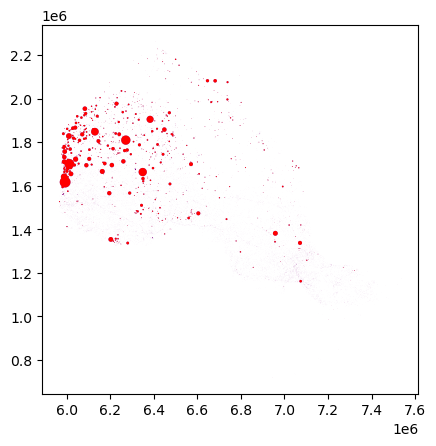

In [ ]:
# Import important modules to be used in this section
from shapely.geometry import Point
import math

# Convert point geometry fire data to polygon geometry by creating a circular buffer around the fire point using the fire size.
# Circular buffer is chosen to get an approximation of the region the fire covers based on the centroid point geometry.

# Function to create circular buffer around a point
def create_circle_buffer(point, radius):
    return point.buffer(radius)

# Convert hectares to square meters
NFDB_point_Ontario_2001['area_sqm'] = NFDB_point_Ontario_2001['SIZE_HA'] * 10000

# Calculate buffer radius from area in square meters
NFDB_point_Ontario_2001['buffer_radius'] = NFDB_point_Ontario_2001['area_sqm'].apply(lambda area: math.sqrt(area / math.pi))

# Create a new column with circular buffers
NFDB_point_Ontario_2001['buffer_geometry'] = NFDB_point_Ontario_2001.apply(lambda row: create_circle_buffer(row['geometry'], row['buffer_radius']), axis=1)

# Convert to GeoDataFrame with buffer geometry
NFDB_point_Ontario_2001_buffer = gpd.GeoDataFrame(NFDB_point_Ontario_2001, geometry='buffer_geometry')
NFDB_point_Ontario_2001_buffer.crs = 'EPSG:3347'

NFDB_point_Ontario_2001_buffer = NFDB_point_Ontario_2001_buffer.rename(columns={'geometry': 'point_geometry'})

# Set the geometry column
NFDB_point_Ontario_2001_buffer = NFDB_point_Ontario_2001_buffer.set_geometry('buffer_geometry')

# Add individual index column
NFDB_point_Ontario_2001_buffer.reset_index(inplace=True)

# Plot the results
ax = NFDB_point_Ontario_2001_buffer.plot(color='blue', alpha=0.5)
NFDB_point_Ontario_2001_buffer.plot(ax=ax, color='red', markersize=10)

In [ ]:
NFDB_point_Ontario_2001_buffer.head()

,index,SRC_AGENCY,FIRE_ID,FIRENAME,LATITUDE,LONGITUDE,YEAR,MONTH,DAY,REP_DATE,...,ACQ_DATE,SRC_AGY2,ECOZONE,ECOZ_REF,ECOZ_NAME,ECOZ_NOM,point_geometry,area_sqm,buffer_radius,buffer_geometry
0,0,ON,RED19,NaN,50.724709,-92.098508,2020,7,3,2020-07-03,...,2021-04-12,ON,6,6a,Boreal Shield West,Bouclier bordal,POINT Z (6183732.734 1620232.609 0.000),6000.0,43.701937,"POLYGON ((6183776.436 1620232.609, 6183776.226..."
1,1,ON,THU63,NaN,49.001309,-89.426207,2020,8,19,2020-08-19,...,2021-04-12,ON,6,6a,Boreal Shield West,Bouclier bordal,POINT Z (6378523.401 1432558.822 0.000),1000.0,17.841241,"POLYGON ((6378541.242 1432558.822, 6378541.156..."
2,2,ON,KEN22,NaN,49.543509,-94.406209,2020,7,9,2020-07-09,...,2021-04-12,ON,6,6a,Boreal Shield West,Bouclier bordal,POINT Z (6016636.740 1493032.361 0.000),2000.0,25.231325,"POLYGON ((6016661.972 1493032.361, 6016661.850..."
3,3,ON,THU23,NaN,50.455109,-89.857708,2020,7,3,2020-07-03,...,2021-04-12,ON,6,6a,Boreal Shield West,Bouclier bordal,POINT Z (6341877.825 1592628.950 0.000),10000.0,56.418958,"POLYGON ((6341934.244 1592628.950, 6341933.972..."
4,4,ON,KLK4,NaN,48.053909,-80.284004,2020,7,5,2020-07-05,...,2021-04-12,ON,6,6b,Boreal Shield East,Bouclier bordal,POINT Z (7061935.777 1402282.324 0.000),4000.0,35.682482,"POLYGON ((7061971.459 1402282.324, 7061971.287..."


# 5. Import Forest Polygon Geometry Data

The polygon geometry data for the forests was created based on 250mx250m pixel coordinates of the forests.

In [ ]:
# Import zipped csv file of Polygon forest data.

import gzip

# Read the gzipped file directly into a DataFrame.
with gzip.open(r'I:\\CME538 Project\\CME538 Project\\processed data ontario only\\250m\\Ontario_Forest_Data.csv.gz', 'rt') as file:
    Ontario_Forest_Data = pd.read_csv(file)

Ontario_Forest_Data.head()

,Unnamed: 0,age_2001,age_2011,age_2019,year_harvested,vol_2001,vol_2011,vol_2015,lon,lat,geometry
0,0,104.0,NaN,NaN,NaN,8.55,NaN,NaN,-84.890501,46.906052,POLYGON ((-84.88863710751139 46.90697579711416...
1,1,104.0,NaN,NaN,NaN,8.55,NaN,NaN,-84.885743,46.912303,POLYGON ((-84.88387922029249 46.91322718112671...
2,2,104.0,NaN,NaN,NaN,8.55,NaN,NaN,-84.887410,46.919261,POLYGON ((-84.88554623463179 46.92018483757417...
3,3,104.0,NaN,NaN,NaN,8.55,NaN,NaN,-84.884197,46.918908,POLYGON ((-84.88233307531861 46.91983171613633...
4,4,57.0,NaN,NaN,NaN,38.69,NaN,NaN,-84.748565,46.962634,POLYGON ((-84.74669588337325 46.96355596569322...


In [ ]:
# Convert the DataFrame of theC forest data to a GeoDataFrame and set the geometry to EPSG code 4269 (the crs in the forest
# polygon DataFrame).

geometry = gpd.GeoSeries.from_wkt(Ontario_Forest_Data['geometry'])

Ontario_Forest_Data_gdf = gpd.GeoDataFrame(Ontario_Forest_Data, geometry=geometry)
Ontario_Forest_Data_gdf.crs = 'EPSG:4269'

Ontario_Forest_Data_gdf.head()

,Unnamed: 0,age_2001,age_2011,age_2019,year_harvested,vol_2001,vol_2011,vol_2015,lon,lat,geometry
0,0,104.0,NaN,NaN,NaN,8.55,NaN,NaN,-84.890501,46.906052,"POLYGON ((-84.88864 46.90698, -84.88915 46.904..."
1,1,104.0,NaN,NaN,NaN,8.55,NaN,NaN,-84.885743,46.912303,"POLYGON ((-84.88388 46.91323, -84.88439 46.911..."
2,2,104.0,NaN,NaN,NaN,8.55,NaN,NaN,-84.887410,46.919261,"POLYGON ((-84.88555 46.92018, -84.88606 46.917..."
3,3,104.0,NaN,NaN,NaN,8.55,NaN,NaN,-84.884197,46.918908,"POLYGON ((-84.88233 46.91983, -84.88285 46.917..."
4,4,57.0,NaN,NaN,NaN,38.69,NaN,NaN,-84.748565,46.962634,"POLYGON ((-84.74670 46.96356, -84.74722 46.961..."


In [ ]:
# Change the crs to same as forest fires point, and drop all the columns except for the geometry
Ontario_Forest_Data_gdf.to_crs('EPSG:3347',inplace=True)

In [ ]:
Ontario_Forest_Data_gdf = Ontario_Forest_Data_gdf[['geometry']]
Ontario_Forest_Data_gdf.head()

<Projected CRS: EPSG:3347>
Name: NAD83 / Statistics Canada Lambert
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Canada - onshore and offshore - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon.
- bounds: (-141.01, 38.21, -40.73, 86.46)
Coordinate Operation:
- name: Statistics Canada Lambert
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

# 6. Merging Fire Data and Forests Polygon GeoDataFrames

In [ ]:
# Merging forests and fire polygon geometry geodataframes using a spatial join.

Ontario_Fire_and_Forests = gpd.sjoin(NFDB_point_Ontario_2001_buffer, Ontario_Forest_Data_gdf,how='inner',predicate = 'intersects')

Ontario_Fire_and_Forests.head()

,index,SRC_AGENCY,FIRE_ID,FIRENAME,LATITUDE,LONGITUDE,YEAR,MONTH,DAY,REP_DATE,...,SRC_AGY2,ECOZONE,ECOZ_REF,ECOZ_NAME,ECOZ_NOM,point_geometry,area_sqm,buffer_radius,buffer_geometry,index_right
0,0,ON,RED19,NaN,50.724709,-92.098508,2020,7,3,2020-07-03,...,ON,6,6a,Boreal Shield West,Bouclier bordal,POINT Z (6183732.734 1620232.609 0.000),6000.0,43.701937,"POLYGON ((6183776.436 1620232.609, 6183776.226...",2323033
0,0,ON,RED19,NaN,50.724709,-92.098508,2020,7,3,2020-07-03,...,ON,6,6a,Boreal Shield West,Bouclier bordal,POINT Z (6183732.734 1620232.609 0.000),6000.0,43.701937,"POLYGON ((6183776.436 1620232.609, 6183776.226...",2323041
1,1,ON,THU63,NaN,49.001309,-89.426207,2020,8,19,2020-08-19,...,ON,6,6a,Boreal Shield West,Bouclier bordal,POINT Z (6378523.401 1432558.822 0.000),1000.0,17.841241,"POLYGON ((6378541.242 1432558.822, 6378541.156...",594313
2,2,ON,KEN22,NaN,49.543509,-94.406209,2020,7,9,2020-07-09,...,ON,6,6a,Boreal Shield West,Bouclier bordal,POINT Z (6016636.740 1493032.361 0.000),2000.0,25.231325,"POLYGON ((6016661.972 1493032.361, 6016661.850...",1234575
3,3,ON,THU23,NaN,50.455109,-89.857708,2020,7,3,2020-07-03,...,ON,6,6a,Boreal Shield West,Bouclier bordal,POINT Z (6341877.825 1592628.950 0.000),10000.0,56.418958,"POLYGON ((6341934.244 1592628.950, 6341933.972...",7346640


Perform a join between Ontario_Fire_and_Forests and Ontario_Forest_Data_gdf to include all the forest data in the combine GeoDataFrame.

In [ ]:
# Set the index of Ontario_Fire_and_Forests to the 'index_right' column.
Ontario_Fire_and_Forests.set_index('index_right',inplace=True)
Ontario_Fire_and_Forests = Ontario_Fire_and_Forests.join(Ontario_Forest_Data_gdf)
Ontario_Fire_and_Forests.head()

,index,SRC_AGENCY,FIRE_ID,FIRENAME,LATITUDE,LONGITUDE,YEAR,MONTH,DAY,REP_DATE,...,SRC_AGY2,ECOZONE,ECOZ_REF,ECOZ_NAME,ECOZ_NOM,point_geometry,area_sqm,buffer_radius,buffer_geometry,geometry
index_right,,,,,,,,,,,,,,,,,,,,,
232,9490,ON,SAU4,NaN,47.013000,-84.775200,2010,4,1,2010-04-01,...,ON,6,6b,Boreal Shield East,Bouclier bordal,POINT Z (6742500.693 1237440.233 0.000),5000.0,39.894228,"POLYGON ((6742540.587 1237440.233, 6742540.395...","POLYGON ((6742553.429 1237567.620, 6742541.119..."
1222,19897,ON,WAW14,NaN,48.301409,-86.152606,2021,7,20,2021-07-20,...,ON,6,6b,Boreal Shield East,Bouclier bordal,POINT Z (6624524.967 1370277.411 0.000),2000.0,25.231325,"POLYGON ((6624550.198 1370277.411, 6624550.076...","POLYGON ((6624707.837 1370531.821, 6624695.526..."
1224,19897,ON,WAW14,NaN,48.301409,-86.152606,2021,7,20,2021-07-20,...,ON,6,6b,Boreal Shield East,Bouclier bordal,POINT Z (6624524.967 1370277.411 0.000),2000.0,25.231325,"POLYGON ((6624550.198 1370277.411, 6624550.076...","POLYGON ((6624695.526 1370282.125, 6624683.216..."
3409,8574,ON,WAW42,NaN,47.753600,-85.887200,2006,7,22,2006-07-22,...,ON,6,6b,Boreal Shield East,Bouclier bordal,POINT Z (6649926.351 1311211.821 0.000),5000.0,39.894228,"POLYGON ((6649966.245 1311211.821, 6649966.053...","POLYGON ((6650067.556 1311211.107, 6650055.245..."
3412,8574,ON,WAW42,NaN,47.753600,-85.887200,2006,7,22,2006-07-22,...,ON,6,6b,Boreal Shield East,Bouclier bordal,POINT Z (6649926.351 1311211.821 0.000),5000.0,39.894228,"POLYGON ((6649966.245 1311211.821, 6649966.053...","POLYGON ((6650079.866 1311460.804, 6650067.556..."


In [ ]:
# Set the geometry to be the geometry of the forest GeoDataFrame which is the 'pixel_geometry' column.
Ontario_Fire_and_Forests.rename(columns={'geometry':'pixel_geometry'},inplace=True)
Ontario_Fire_and_Forests.head(2)

,index,SRC_AGENCY,FIRE_ID,FIRENAME,LATITUDE,LONGITUDE,YEAR,MONTH,DAY,REP_DATE,...,SRC_AGY2,ECOZONE,ECOZ_REF,ECOZ_NAME,ECOZ_NOM,point_geometry,area_sqm,buffer_radius,buffer_geometry,pixel_geometry
index_right,,,,,,,,,,,,,,,,,,,,,
232,9490,ON,SAU4,NaN,47.013000,-84.775200,2010,4,1,2010-04-01,...,ON,6,6b,Boreal Shield East,Bouclier bordal,POINT Z (6742500.693 1237440.233 0.000),5000.0,39.894228,"POLYGON ((6742540.587 1237440.233, 6742540.395...","POLYGON ((6742553.429 1237567.620, 6742541.119..."
1222,19897,ON,WAW14,NaN,48.301409,-86.152606,2021,7,20,2021-07-20,...,ON,6,6b,Boreal Shield East,Bouclier bordal,POINT Z (6624524.967 1370277.411 0.000),2000.0,25.231325,"POLYGON ((6624550.198 1370277.411, 6624550.076...","POLYGON ((6624707.837 1370531.821, 6624695.526..."


# 7. Area of Intersect Between the Merged Fire and Forest Polygons

Calculate the area of intersection between the merged fire and forest polygons.

In [ ]:
#'get_overlay_area' function to calculate the area of intersection

def get_overlay_area(data_left,data_right):
    area = data_left.intersection(data_right).area
    return area

In [ ]:
# Create new GeoDataFrames; 'buffer' which contains the 'buffer_geometry' column for the fires and the 'pixel' which contains
# the 'pixel_geometry' column from the forest GeoDataFrame. The new GeoDataFrames will be used when calculating the overlay area.

buffer = Ontario_Fire_and_Forests[['buffer_geometry']].set_crs(3347)
print(buffer)
pixel = Ontario_Fire_and_Forests[['pixel_geometry']].set_geometry("pixel_geometry").set_crs(3347)
print(pixel)

                                               buffer_geometry
index_right                                                   
232          POLYGON ((6742540.587 1237440.233, 6742540.395...
1222         POLYGON ((6624550.198 1370277.411, 6624550.076...
1224         POLYGON ((6624550.198 1370277.411, 6624550.076...
3409         POLYGON ((6649966.245 1311211.821, 6649966.053...
3412         POLYGON ((6649966.245 1311211.821, 6649966.053...
...                                                        ...
15091520     POLYGON ((7536289.007 1173106.298, 7536287.881...
15091521     POLYGON ((7536289.007 1173106.298, 7536287.881...
15091522     POLYGON ((7536289.007 1173106.298, 7536287.881...
15091523     POLYGON ((7536289.007 1173106.298, 7536287.881...
15091524     POLYGON ((7536289.007 1173106.298, 7536287.881...

[563882 rows x 1 columns]
                                                pixel_geometry
index_right                                                   
232          POLYGON ((67425

In [ ]:
# Calculate the overlay area for each corresponding pair of geometries from the fire and forest geometry gdf's using the
#'get_overlay_area' function defined above.

area = []
for i in range(len(pixel)):
    area.append(get_overlay_area(buffer.iloc[i,0],pixel.iloc[i,0]))

In [ ]:
# Add the overlay area to the merged fire and forest gdf as a new column called 'area_intersect'.
# Add another column called 'area_intersect_perc' which contains the ratio of the area of overlay to the forest area obtained
# from the 20m*250m pixels.

Ontario_Fire_and_Forests['area_intersect'] = area
Ontario_Fire_and_Forests['area_intersect_perc'] = area/pixel.area

In [ ]:
# Display the new gdf with the new columns added.

Ontario_Fire_and_Forests.head()

,index,SRC_AGENCY,FIRE_ID,FIRENAME,LATITUDE,LONGITUDE,YEAR,MONTH,DAY,REP_DATE,...,ECOZ_REF,ECOZ_NAME,ECOZ_NOM,point_geometry,area_sqm,buffer_radius,buffer_geometry,pixel_geometry,area_intersect,area_intersect_perc
index_right,,,,,,,,,,,,,,,,,,,,,
232,9490,ON,SAU4,NaN,47.013000,-84.775200,2010,4,1,2010-04-01,...,6b,Boreal Shield East,Bouclier bordal,POINT Z (6742500.693 1237440.233 0.000),5000.0,39.894228,"POLYGON ((6742540.587 1237440.233, 6742540.395...","POLYGON ((6742553.429 1237567.620, 6742541.119...",4991.971965,0.079872
1222,19897,ON,WAW14,NaN,48.301409,-86.152606,2021,7,20,2021-07-20,...,6b,Boreal Shield East,Bouclier bordal,POINT Z (6624524.967 1370277.411 0.000),2000.0,25.231325,"POLYGON ((6624550.198 1370277.411, 6624550.076...","POLYGON ((6624707.837 1370531.821, 6624695.526...",368.653991,0.005898
1224,19897,ON,WAW14,NaN,48.301409,-86.152606,2021,7,20,2021-07-20,...,6b,Boreal Shield East,Bouclier bordal,POINT Z (6624524.967 1370277.411 0.000),2000.0,25.231325,"POLYGON ((6624550.198 1370277.411, 6624550.076...","POLYGON ((6624695.526 1370282.125, 6624683.216...",1628.134795,0.026050
3409,8574,ON,WAW42,NaN,47.753600,-85.887200,2006,7,22,2006-07-22,...,6b,Boreal Shield East,Bouclier bordal,POINT Z (6649926.351 1311211.821 0.000),5000.0,39.894228,"POLYGON ((6649966.245 1311211.821, 6649966.053...","POLYGON ((6650067.556 1311211.107, 6650055.245...",2991.405964,0.047862
3412,8574,ON,WAW42,NaN,47.753600,-85.887200,2006,7,22,2006-07-22,...,6b,Boreal Shield East,Bouclier bordal,POINT Z (6649926.351 1311211.821 0.000),5000.0,39.894228,"POLYGON ((6649966.245 1311211.821, 6649966.053...","POLYGON ((6650079.866 1311460.804, 6650067.556...",2000.566001,0.032009


In [ ]:
# Remove any duplicate rows which may have been formed during the merge.

Ontario_Fire_and_Forests[Ontario_Fire_and_Forests.duplicated('geometry',keep=False)]

,index,SRC_AGENCY,FIRE_ID,FIRENAME,LATITUDE,LONGITUDE,YEAR,MONTH,DAY,REP_DATE,...,SRC_AGY2,ECOZONE,ECOZ_REF,ECOZ_NAME,ECOZ_NOM,point_geometry,area_sqm,buffer_radius,buffer_geometry,geometry
index_right,,,,,,,,,,,,,,,,,,,,,
96800,12520,ON,WAW102,NaN,48.6023,-86.0166,2001,8,13,2001-08-13,...,ON,6,6b,Boreal Shield East,Bouclier bordal,POINT Z (6631521.713 1404585.329 0.000),1000.000015,17.841241,"POLYGON ((6631539.554 1404585.329, 6631539.468...","POLYGON ((6631650.302 1404731.451, 6631637.992..."
96800,12914,ON,WAW30,NaN,48.6023,-86.0166,2001,7,31,2001-07-31,...,ON,6,6b,Boreal Shield East,Bouclier bordal,POINT Z (6631521.713 1404585.329 0.000),1000.000015,17.841241,"POLYGON ((6631539.554 1404585.329, 6631539.468...","POLYGON ((6631650.302 1404731.451, 6631637.992..."
98679,8302,ON,WAW22,NaN,48.6787,-85.9790,2011,7,25,2011-07-25,...,ON,6,6b,Boreal Shield East,Bouclier bordal,POINT Z (6633500.921 1413312.672 0.000),2000.000030,25.231325,"POLYGON ((6633526.152 1413312.672, 6633526.031...","POLYGON ((6633579.346 1413396.974, 6633567.036..."
98679,17449,ON,WAW27,NaN,48.6778,-85.9818,2016,8,2,2016-08-02,...,ON,6,6b,Boreal Shield East,Bouclier bordal,POINT Z (6633304.608 1413193.812 0.000),1000.000015,17.841241,"POLYGON ((6633322.449 1413193.812, 6633322.363...","POLYGON ((6633579.346 1413396.974, 6633567.036..."
108515,8320,ON,WAW4,NaN,48.6911,-85.6357,2007,4,25,2007-04-25,...,ON,6,6b,Boreal Shield East,Bouclier bordal,POINT Z (6658563.933 1417094.409 0.000),5000.000000,39.894228,"POLYGON ((6658603.828 1417094.409, 6658603.635...","POLYGON ((6658795.227 1417159.869, 6658782.916..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14915499,18893,ON,PEM1,NaN,45.2244,-76.8328,2015,8,20,2015-08-20,...,ON,6,6b,Boreal Shield East,Bouclier bordal,POINT Z (7388905.555 1147094.107 0.000),1000.000015,17.841241,"POLYGON ((7388923.396 1147094.107, 7388923.311...","POLYGON ((7389133.978 1147119.255, 7389121.667..."
14940884,6366,ON,KEM1,NaN,45.2618,-76.4912,2005,5,12,2005-05-12,...,ON,6,6b,Boreal Shield East,Bouclier bordal,POINT Z (7414386.515 1157651.639 0.000),5000.000000,39.894228,"POLYGON ((7414426.410 1157651.639, 7414426.218...","POLYGON ((7414444.852 1157885.969, 7414432.542..."
14940884,6369,ON,KEM4,NaN,45.2627,-76.4912,2005,8,4,2005-08-04,...,ON,6,6b,Boreal Shield East,Bouclier bordal,POINT Z (7414362.184 1157750.325 0.000),4000.000060,35.682483,"POLYGON ((7414397.867 1157750.325, 7414397.695...","POLYGON ((7414444.852 1157885.969, 7414432.542..."


In [ ]:
# Export the merged GoeDataFrame as a compressed csv file.

Ontario_Fire_and_Forests.to_csv('Ontario_fire_in_fores_coordinates.csv.gz',compression='gzip',header=Ontario_Fire_and_Forests.columns)